# Classification Fake News Climat – Notebook ML

In [34]:
import pandas as pd

df = pd.read_csv("hf://datasets/readerbench/fakenews-climate-fr/fake-fr.csv")
df.to_csv("climate.csv")
df.head()

,Text,Label
0,\nUne réflexion collective qui est aussi quoi ...,fake
1,\nDès l’élaboration de la Convention-cadre des...,true
2,"\n""On peut parler d'invasion, d'invasion génér...",true
3,"\nLa Rochelle, le 14 mars 2008. Un navire en p...",biased
4,\nJ’ai eu le plaisir de visiter le Japon il n’...,fake


In [35]:
#pour supprimer les lignes avec 'biased'
#df = df[df['Label'] != 'biased']

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2434 entries, 0 to 2433
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2434 non-null   object
 1   Label   2434 non-null   object
dtypes: object(2)
memory usage: 38.2+ KB


In [37]:
df.describe(include='all')

,Text,Label
count,2434,2434
unique,2434,3
top,\nLa France est à nouveau victime d'un épisode...,true
freq,1,1485


In [49]:
import pandas as pd
import random
import nltk
from nltk.corpus import wordnet

# Téléchargement WordNet si nécessaire
nltk.download('wordnet')
nltk.download('omw-1.4')

# Fonctions d'augmentation
def synonym_replace(sentence, n=1):
    words = sentence.split()
    new_words = words.copy()
    for _ in range(n):
        word_to_replace = random.choice(words)
        synonyms = wordnet.synsets(word_to_replace)
        if synonyms:
            new_word = synonyms[0].lemmas()[0].name()
            if new_word != word_to_replace:
                new_words[words.index(word_to_replace)] = new_word
    return ' '.join(new_words)

def random_swap(sentence, n=1):
    words = sentence.split()
    for _ in range(n):
        if len(words) < 2:
            break
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)


# Fonction combinée pour augmenter un texte
def augment_text(sentence, num_augmented=3):
    augmented = []
    for _ in range(num_augmented):
        technique = random.choice(['synonym', 'swap', 'delete'])
        if technique == 'synonym':
            augmented.append(synonym_replace(sentence))
        elif technique == 'swap':
            augmented.append(random_swap(sentence))
    return augmented

# Exemple avec ton dataframe
augmented_data = []

for _, row in df.iterrows():
    new_texts = augment_text(row['Text'], num_augmented=3)  # 3 variantes par texte
    for text in new_texts:
        augmented_data.append({'Text': text, 'Label': row['Label']})

augmented_df = pd.DataFrame(augmented_data)

# Combiner avec le dataset original
df = pd.concat([df, augmented_df], ignore_index=True)
print(df)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DAGHY\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DAGHY\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


                                                   Text   Label
0     \nUne réflexion collective qui est aussi quoi ...    fake
1     \nDès l’élaboration de la Convention-cadre des...    true
2     \n"On peut parler d'invasion, d'invasion génér...    true
3     \nLa Rochelle, le 14 mars 2008. Un navire en p...  biased
4     \nJ’ai eu le plaisir de visiter le Japon il n’...    fake
...                                                 ...     ...
7331  À elles seules, les glaces du Groenland les l'...    true
7332  À elles seules, les glaces du Groenland contie...    true
7333  La semaine dernière, le monde par regardait le...    true
7334  La France est à nouveau victime d'un épisode d...    true
7335  La France est à nouveau victime d'un épisode d...    true

[7336 rows x 2 columns]


## Préparation des données

In [50]:
df = df.dropna()

X = df['Text']
y = df['Label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## 1) Logistic Regression + GridSearchCV

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Pipeline
pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),  # Limité pour accélérer
    ('lr', LogisticRegression(max_iter=2000))
])

# Grille d'hyperparamètres
param_grid_lr = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'lr__C': [0.1, 1, 3, 10],
    'lr__penalty': ['l2'],
    'lr__solver': ['lbfgs', 'liblinear']
}

# GridSearch
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=3, n_jobs=-1, verbose=2)

grid_lr.fit(X_train, y_train)

print("🔧 Meilleurs paramètres LR :")
print(grid_lr.best_params_)

y_pred_lr = grid_lr.predict(X_test)
print("\n📊 Rapport de classification (Logistic Regression) :")
print(classification_report(y_test, y_pred_lr))


Fitting 3 folds for each of 16 candidates, totalling 48 fits
🔧 Meilleurs paramètres LR :
{'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs', 'tfidf__ngram_range': (1, 2)}

📊 Rapport de classification (Logistic Regression) :
              precision    recall  f1-score   support

      biased       0.95      0.88      0.91       193
        fake       0.94      0.98      0.96       383
        true       0.98      0.99      0.98       892

    accuracy                           0.97      1468
   macro avg       0.96      0.95      0.95      1468
weighted avg       0.97      0.97      0.97      1468



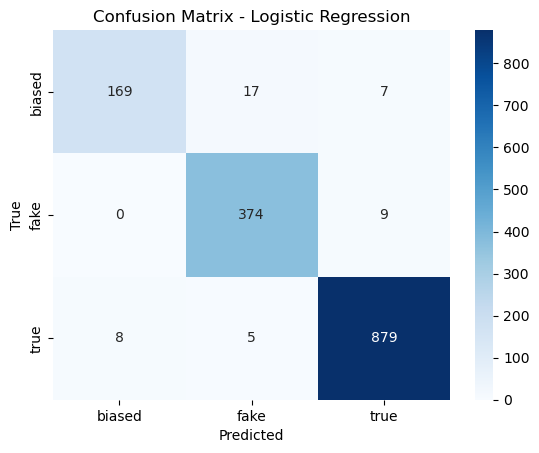

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Récupérer les vraies étiquettes et les prédictions
y_true = y_test
y_pred = y_pred_lr

labels = ["biased", "fake", "true"]

cm = confusion_matrix(y_true, y_pred, labels=labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


## 2) SVM linéaire (LinearSVC) + GridSearchCV

In [53]:
from sklearn.svm import LinearSVC

pipe_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svm', LinearSVC())
])

param_grid_svm = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'svm__C': [0.1, 1, 3, 10],
    'svm__loss': ['hinge', 'squared_hinge']
}

grid_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=3, n_jobs=-1, verbose=2)

grid_svm.fit(X_train, y_train)

print("🔧 Meilleurs paramètres SVM :")
print(grid_svm.best_params_)

y_pred_svm = grid_svm.predict(X_test)
print("\n📊 Rapport de classification (SVM) :")
print(classification_report(y_test, y_pred_svm))


Fitting 3 folds for each of 16 candidates, totalling 48 fits
🔧 Meilleurs paramètres SVM :
{'svm__C': 3, 'svm__loss': 'squared_hinge', 'tfidf__ngram_range': (1, 1)}

📊 Rapport de classification (SVM) :
              precision    recall  f1-score   support

      biased       0.98      0.92      0.95       193
        fake       0.97      0.98      0.97       383
        true       0.99      0.99      0.99       892

    accuracy                           0.98      1468
   macro avg       0.98      0.96      0.97      1468
weighted avg       0.98      0.98      0.98      1468



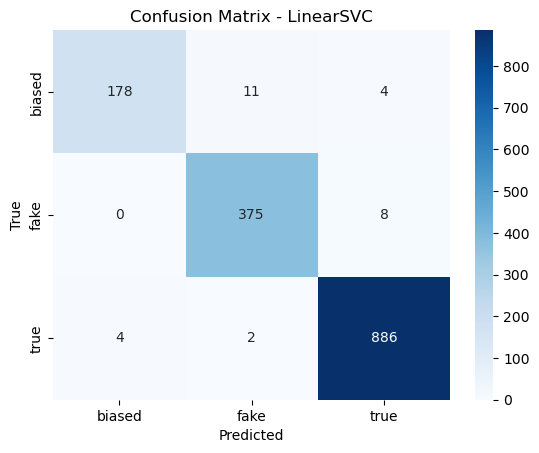

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Récupérer les vraies étiquettes et les prédictions
y_true = y_test
y_pred = y_pred_svm

labels = ["biased", "fake", "true"]

cm = confusion_matrix(y_true, y_pred, labels=labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - LinearSVC")
plt.show()


Les paramètres TF-IDF contrôlent comment on transforme le texte. ; Les paramètres RF contrôlent comment le modèle apprend.

Le GridSearch teste toutes les combinaisons pour trouver celle donnant le meilleur score.

🎯 Est-ce que max_features=5000 est suffisant ?
👉 Oui, dans la majorité des cas.

Pour la plupart des tâches de classification de texte, un vocabulaire de 5 000 mots suffit pour :

capturer les mots les plus discriminants, entraîner plus vite, éviter d’avoir un modèle trop lourd, limiter le bruit des mots rares

### Sauvegarde du modèle

In [55]:
import joblib

# Sauvegarder le meilleur modèle SVM trouvé par GridSearchCV
joblib.dump(grid_svm.best_estimator_, "best_svm_model.pkl")
print("Modèle sauvegardé sous best_svm_model.pkl")


Modèle sauvegardé sous best_svm_model.pkl


In [56]:
# Sauvegarder le meilleur modèle SVM trouvé par GridSearchCV
joblib.dump(grid_lr.best_estimator_, "best_reg_log_model.pkl")
print("Modèle sauvegardé sous best_reg_log_model.pkl")

Modèle sauvegardé sous best_reg_log_model.pkl


### Tester le modèle SVM - résultat en vrai/faux

In [72]:
import joblib

# Charger le modèle
model_svm = joblib.load("best_svm_model.pkl")

# Nouveaux textes à classer
new_texts = [
    "Le climat sur Terre n'a pas changé depuis 100 ans, c'est un mythe inventé par les médias."
]

# Prédire les labels
pred_labels_svm = model_svm.predict(new_texts)

# Afficher les résultats
for text, label in zip(new_texts, pred_labels_svm):
    print(f"Texte : {text}")
    print(f"Label prédit : {label}")
    print("-"*50)


Texte : Le climat sur Terre n'a pas changé depuis 100 ans, c'est un mythe inventé par les médias.
Label prédit : fake
--------------------------------------------------


### Tester le modèle Reg_Log - résultat en vrai/faux

In [71]:
# Charger le modèle
model_lr = joblib.load("best_reg_log_model.pkl")

# Nouveaux textes à classer
new_texts = [
    "Le climat sur Terre n'a pas changé depuis 100 ans, c'est un mythe inventé par les médias."
]

# Prédire les labels
pred_labels_lr = model_lr.predict(new_texts)

# Afficher les résultats
for text, label in zip(new_texts, pred_labels_lr):
    print(f"Texte : {text}")
    print(f"Label prédit : {label}")
    print("-"*50)

Texte : Le climat sur Terre n'a pas changé depuis 100 ans, c'est un mythe inventé par les médias.
Label prédit : fake
--------------------------------------------------


### Tester le modèle - résultat en pourcentage

In [47]:
#from sklearn.calibration import CalibratedClassifierCV

# Envelopper le SVM pour obtenir des probabilités
#calibrated_svm = CalibratedClassifierCV(grid_svm.best_estimator_, cv='prefit')
#calibrated_svm.fit(X_train, y_train)

# Obtenir les probabilités de prédiction pour un exemple (ou plusieurs)
#probs = calibrated_svm.predict_proba(X_test)

# Si tu veux seulement la première observation :
#probs_dict = dict(zip(calibrated_svm.classes_, probs[0]))

#print(probs_dict)


### Exemple de texts

In [ ]:
test_texts = [
    # Textes vrais
    "Le niveau des océans augmente chaque année en raison de la fonte des glaciers.",
    "Les scientifiques confirment que le réchauffement climatique est causé par les activités humaines.",
    "La concentration de CO2 dans l'atmosphère est la plus élevée depuis 800 000 ans.",
    "Les événements météorologiques extrêmes deviennent plus fréquents à cause du changement climatique.",
    "Les énergies renouvelables comme le solaire et l'éolien réduisent les émissions de gaz à effet de serre.",
    "La déforestation contribue fortement à l'augmentation du CO2 atmosphérique.",
    "La glace de l'Arctique fond plus rapidement que prévu selon les dernières études.",
    "Les océans absorbent une partie du CO2 produit par l'homme, ce qui entraîne leur acidification.",
    "Les villes doivent adapter leurs infrastructures pour faire face aux canicules et inondations.",
    "Les politiques climatiques visent à limiter le réchauffement global à 1,5°C.",

    # Textes faux
    "Le climat sur Terre n'a pas changé depuis 100 ans, c'est un mythe inventé par les médias.",
    "Le CO2 est bénéfique et ne contribue pas au réchauffement climatique.",
    "Les glaciers fondent uniquement à cause du soleil et non à cause des activités humaines.",
    "Il n'y a aucune preuve scientifique que les températures mondiales augmentent.",
    "Le réchauffement climatique est une invention des gouvernements pour taxer les citoyens.",
    "Les ouragans et tornades sont naturels et n'ont aucun lien avec le climat.",
    "La fonte des glaciers est due à un cycle naturel, pas aux humains.",
    "La pollution n'affecte pas le climat, elle ne touche que la santé humaine.",
    "Les énergies renouvelables sont inefficaces et ne réduisent pas le CO2.",
    "Il n'y a pas de consensus scientifique sur le changement climatique."
]
